In [9]:
import csv
from collections import defaultdict
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import sklearn.metrics as metrics


In [10]:
# load data

class Child():
    def __init__(self, data):
        self.id = data[1]
        self.family = data[0]
        self.relatedness = data[2]
        self.sex = data[5]
        self.age = None if data[6]=='' or int(data[6])<0 or int(data[6])>100 else int(data[6])
        self.diagnoses = set(data[7].split(','))
        self.asd = data[8]
        self.premature = data[9]
        self.gestation = 40 if data[10]=='' else int(data[10])
        self.verbal = int(data[11])
        self.sleep = data[12]
        self.hearing = data[13]
        self.vision = data[14]
        self.noise = data[15]
        self.motor = data[16]
        self.metabolic = data[17]
        self.gi = data[18]
        self.infections = data[19]
        self.seizures = data[20]
        
    def __str__(self):
        return 'Child(id=%s, fam=%s)' % (self.id, self.family)

fam_to_children = defaultdict(list)
children = []
with open('../data/kfPedsFileExport_09-12-2022.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    for line in reader:
        child = Child(line)
        fam_to_children[child.family].append(child)
        children.append(child)

In [17]:
child_to_index = dict([(x.id, i) for i, x in enumerate(children)])

# -1 is unknown; 0 is NT behavior; 1 is AUT behavior
scq = -np.ones((len(children), 40))

aut_behavior = ['0', '0'] + ['1']*6 + ['0'] + ['1']*9 + ['0']*22
missing_from_ped = list()

with open('../data/kidsFirstAdminExport_09-20-2022_SCQ.csv', 'r') as f:
    reader = csv.reader(f)
    
    # header
    next(reader)
    header = next(reader)
    scq_questions = header[20:60]
    next(reader)
    next(reader)
    next(reader)
    
    for line in reader:
        child = line[0]
        if child in child_to_index:
            scq[child_to_index[child], :40] = [-1 if x=='' else 1 if x==aut_behavior[i] else 0 for i, x in enumerate(line[20:60])]
        else:
            missing_from_ped.append(child)
            
print('missing from ped', len(missing_from_ped))
has_data = np.any(scq!=-1, axis=1)
print('missing from scq', np.sum(~has_data))
print('data complete', np.sum(has_data))


missing from ped 13
missing from scq 1886
data complete 1233


In [18]:
# remove children missing scq
children = [x for i, x in enumerate(children) if has_data[i]]
child_to_index = dict([(x.id, i) for i, x in enumerate(children)])

scq = scq[has_data, :]
print(len(children), scq.shape)

1233 (1233, 40)


In [19]:
# asd: yes/no
# premature: yes/no/missing=''
# sleep: yes/no/missing=''
# hearing: yes_hearingaids/yes_other/no/missing=''
# vision: yes/yes_other/no
# noise: yes_severe/yes_moderate/yes_mild/yes_other/yes_prefers/no/missing=''
# motor: yes/yes_some/no
# metabolic: yes/no/missing=''
# gi: yes/no/''
# infections: yes_constantly/yes_often/yes_slightly/no/missing=''
# seizures: yes/no/missing=''
# gestation: 23-40
# verbal: 1-10

one_hot_attributes = np.zeros((len(children), 20))
cat_attrs = ['asd', 'noise', 'motor', 'sleep', 'gi', 'premature', 'hearing', 'vision', 'metabolic', \
             'infections', 'seizures']

one_hot_labels = []
for attr in cat_attrs:
    options = [y for y in set([getattr(x, attr) for x in children]) if y!='' and y!='no']
    one_hot_attributes[:, len(one_hot_labels):(len(one_hot_labels)+len(options))] = np.array([[int(getattr(x, attr)==opt) for x in children] for opt in options]).T
    one_hot_labels.extend(['%s:%s' % (attr, opt) for opt in options])
    

In [23]:
is_verbal = scq[:, 0]==0
print(np.sum(is_verbal))

is_aut = np.array([child.asd=='yes' for child in children])

offset = np.ones((len(children), 1))

is_train = np.ones((len(children),), dtype=bool)
for fam, cs in fam_to_children.items():
    if random.random() < 0.1:
        for child in cs:
            if child.id in child_to_index:
                is_train[child_to_index[child.id]] = False
            
print('train', np.sum(is_train), 'test', np.sum(~is_train))

1022
train 1083 test 150


In [40]:
# logistic regression

def tune_params(y, data, alphas=[0.01, 0.1, 1, 10]):
    # 5-fold cross-validation
    folds = np.random.randint(0, 5, size=(len(y),))
    rocs = np.zeros((len(alphas), 5))
    for i, alpha in enumerate(alphas):
        for fold in range(5):
            model = sm.Logit(y[folds!=fold], data[folds!=fold, :])
            result = model.fit_regularized(method='l1', alpha=alpha, disp=False)
            rocs[i, fold] = metrics.roc_auc_score(y[folds==fold], result.predict(data[folds==fold, :]))
    print(np.median(rocs, axis=1))
    best_alpha = alphas[np.argmax(np.median(rocs, axis=1))]
    
    model = sm.Logit(y, data)
    result = model.fit_regularized(method='l1', alpha=best_alpha, disp=False)

    if not result.mle_retvals["converged"]:
        result = None
    return result
    

def train_models(attr, alpha=0.1):
    has_y = np.array([True if ('yes' in getattr(child, attr)) or (getattr(child, attr)=='no') else False for child in children])
    y = np.array([1 if 'yes' in getattr(child, attr) else 0 for child in children])
    is_other_attr = np.array([not x.startswith(attr) for x in one_hot_labels])

    ## model using only autism
    #modelaut = sm.Logit(y[is_train & has_y], np.hstack((offset, is_aut[:, np.newaxis]))[is_train & has_y, :])
    #resultaut = modelaut.fit_regularized(method='l1', alpha=alpha)
    #if not resultaut.mle_retvals["converged"]:
    #    resultaut = None
    ##print(result8.summary())

    ## model using all but first 8 questions
    #assert np.all(scq[:, 8:]>=0)
    #model8 = sm.Logit(y[is_train & has_y], np.hstack((offset, scq[:, 8:]))[is_train & has_y, :])
    #result8 = model8.fit_regularized(method='l1', alpha=alpha)
    #if not result8.mle_retvals["converged"]:
    #    result8 = None
    ##print(result8.summary())

    # model inclusing only verbal children
    assert np.all(scq[is_verbal, :]>=0)
    resultv = tune_params(y[is_train & is_verbal & has_y], 
                          np.hstack((offset, scq[:, 1:]))[is_train & is_verbal & has_y, :])

    # model including only other attributes
    resultattr = tune_params(y[is_train & has_y], 
                             np.hstack((offset, one_hot_attributes[:, is_other_attr]))[is_train & has_y, :])

    ## model using all but first 8 questions + attr
    #model8attr = sm.Logit(y[is_train & has_y], np.hstack((offset, scq[:, 8:], one_hot_attributes[:, is_other_attr]))[is_train & has_y, :])
    #result8attr = model8attr.fit_regularized(method='l1', alpha=alpha)
    #if not result8attr.mle_retvals["converged"]:
    #    result8attr = None
    ##print(result8.summary())

    # model inclusing only verbal children + attr
    resultvattr = tune_params(y[is_train & is_verbal & has_y], 
                              np.hstack((offset, scq[:, 1:], one_hot_attributes[:, is_other_attr]))[is_train & is_verbal & has_y, :])
    
    return resultattr, resultv, resultvattr, has_y, y, is_other_attr
    

//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 14 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.92383901 0.91352912 0.92941176 0.93089783]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 6 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimm

[0.7737629  0.77524883 0.77521224 0.75520218]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 21 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.92128619 0.91453616 0.9211103  0.93267592]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 10 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.81319038 0.78667724 0.81887589 0.82521118]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 16 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimm

[0.76372998 0.76625667 0.76358696 0.75594059]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 55 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 55 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.79893455 0.7870624  0.80507937 0.79693122]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 15 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.74732421 0.73397914 0.75084677 0.76535948]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 7 out of 19 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 9 out of 19 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimm

[0.79303331 0.7921434  0.79227053 0.78324434]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 19 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 20 out of 58 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trim

[0.78851254 0.79056172 0.80653595 0.80231437]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 15 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.71359712 0.70155423 0.70820144 0.70701058]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 6 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trim

[0.73895931 0.73834594 0.73803926 0.72618074]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 15 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.74229217 0.72179177 0.74015748 0.73498533]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 15 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.64097561 0.61934236 0.6417561  0.6435122 ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 6 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 8 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimm

[0.69800514 0.67774682 0.69059846 0.68604917]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 18 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trim

[0.68971793 0.68845316 0.69545596 0.66596639]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 10 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 14 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.54924579 0.55235138 0.55634428 0.5       ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 7 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 5 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimm

[0.57861111 0.57631944 0.60291667 0.55604651]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 20 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.53283052 0.56417112 0.53602484 0.50050201]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 15 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 10 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.67891121 0.67702096 0.64825581 0.5       ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 15 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 10 out of 19 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.74850498 0.76046512 0.75588371 0.62090448]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 19 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 23 out of 58 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trim

[0.58914729 0.54699612 0.61006944 0.5       ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.57881438 0.56787634 0.58315118 0.46899297]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 7 out of 19 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 5 out of 19 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimm

[0.65259804 0.64740196 0.65063725 0.61380684]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 8 out of 19 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 18 out of 58 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trim

[0.5984127  0.6021721  0.61578947 0.5946533 ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 11 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.4619883  0.50643275 0.4622807  0.5       ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 7 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimm

[0.725625  0.725625  0.8294686 0.5      ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 22 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 23 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.58060109 0.6489071  0.65801457 0.5       ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 11 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 14 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.64109756 0.64556962 0.66259275 0.6664886 ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 7 out of 18 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 8 out of 18 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimm

[0.68828493 0.68802521 0.69907771 0.67129929]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 24 out of 57 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 57 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.70125786 0.68810749 0.7111465  0.72548148]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.61111111 0.57816092 0.65576592 0.5       ]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 4 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimm

[0.72157016 0.72078769 0.77404526 0.63641937]


//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 20 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 19 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Tri

[0.58448896 0.6488764  0.63328197 0.5       ]


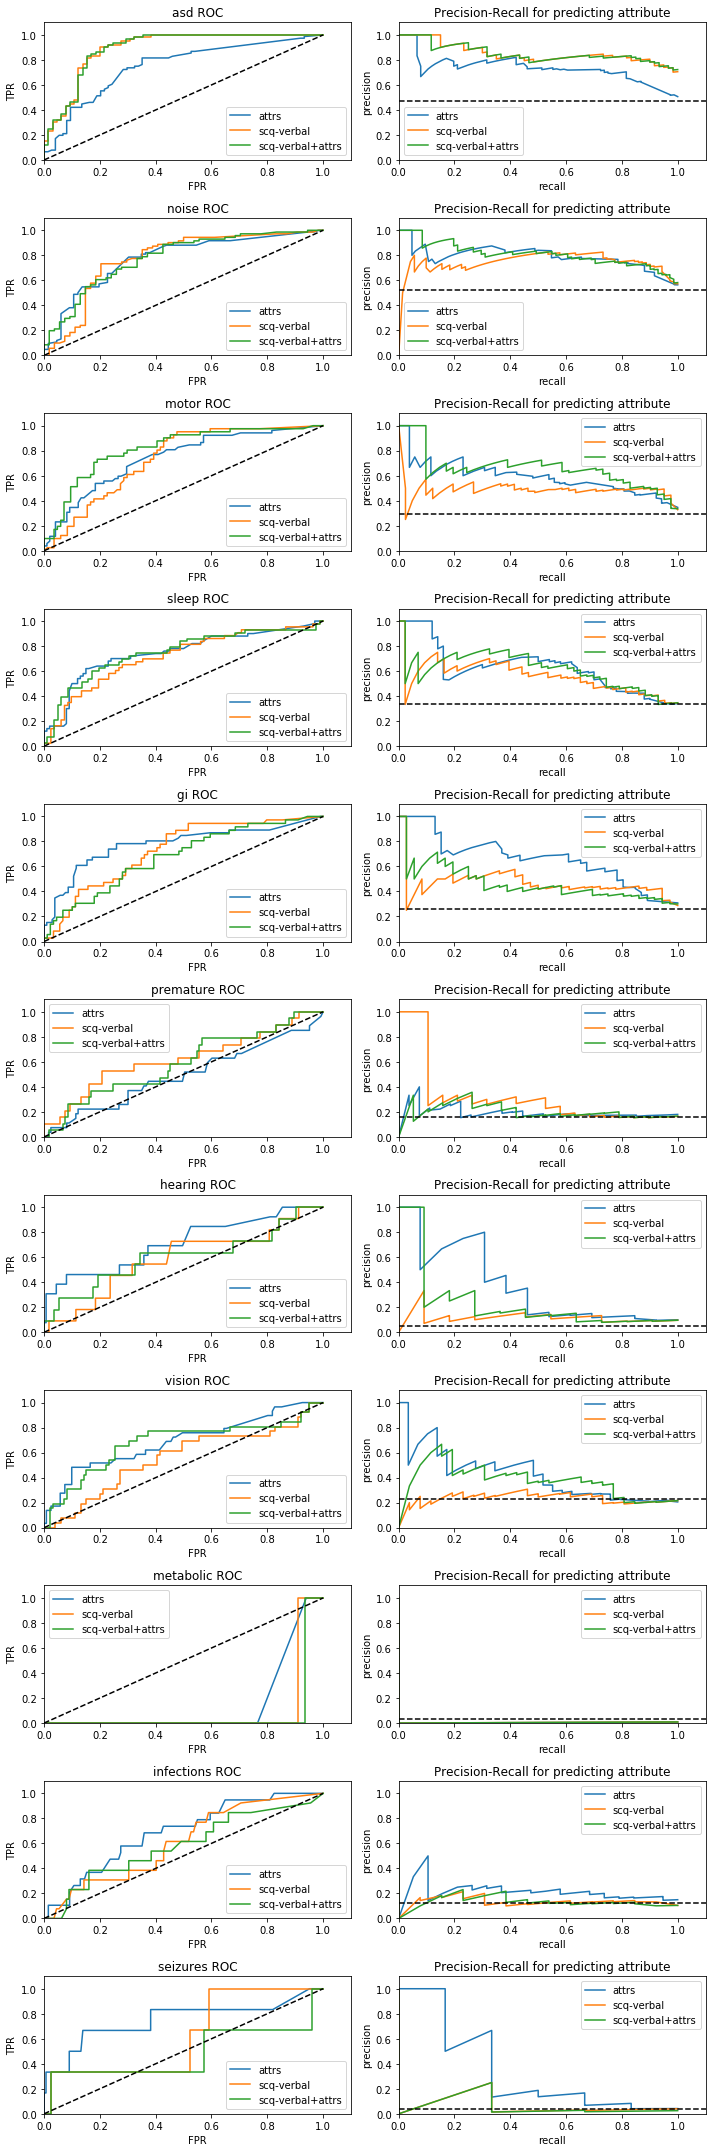

In [41]:
plt.figure(figsize=(10, 30))

for i, attr in enumerate(cat_attrs):
    resultattr, resultv, resultvattr, has_y, y, is_other_attr = train_models(attr)

    def plot_roc(y, result, data, label):
        if result is not None:
            fpr, tpr, _ = metrics.roc_curve(y, result.predict(data))
            plt.plot(fpr, tpr, label=label)

    plt.subplot(len(cat_attrs), 2, 2*i + 1)
    #plot_roc(y[has_y], resultaut, 'aut-only')
    plot_roc(y[~is_train & has_y], resultattr, 
             np.hstack((offset, one_hot_attributes[:, is_other_attr]))[~is_train & has_y, :], 
             'attrs')
    #plot_roc(y[has_y], result8, 'scq-drop8')
    plot_roc(y[~is_train & is_verbal & has_y], resultv, 
             np.hstack((offset, scq[:, 1:]))[~is_train & is_verbal & has_y, :],
             'scq-verbal')
    #plot_roc(y[has_y], result8attr, 'scq-drop8+attrs')
    plot_roc(y[~is_train & is_verbal & has_y], resultvattr, 
             np.hstack((offset, scq[:, 1:], one_hot_attributes[:, is_other_attr]))[~is_train & is_verbal & has_y, :], 
             'scq-verbal+attrs')
    plt.title('%s ROC' % attr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.legend()
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])

    def plot_pr(y, result, data, label):
        if result is not None:
            precision, recall, _ = metrics.precision_recall_curve(y, result.predict(data))
            plt.plot(recall, precision, label=label)

    def plot_pr_reverse(y, result, label):
        if result is not None:
            precision, recall, _ = metrics.precision_recall_curve(y, result.predict(), pos_label=0)
            plt.plot(recall, precision, label=label)

    plt.subplot(len(cat_attrs), 2, 2*i + 2)
    #plot_pr(y[has_y], resultaut, 'aut-only')
    plot_pr(y[~is_train & has_y], resultattr, 
             np.hstack((offset, one_hot_attributes[:, is_other_attr]))[~is_train & has_y, :], 
            'attrs')
    #plot_pr(y[has_y], result8, 'scq-drop8')
    plot_pr(y[~is_train & is_verbal & has_y], resultv, 
             np.hstack((offset, scq[:, 1:]))[~is_train & is_verbal & has_y, :], 
            'scq-verbal')
    #plot_pr(y[has_y], result8attr, 'scq-drop8+attrs')
    plot_pr(y[~is_train & is_verbal & has_y], resultvattr, 
             np.hstack((offset, scq[:, 1:], one_hot_attributes[:, is_other_attr]))[~is_train & is_verbal & has_y, :], 
            'scq-verbal+attrs')
    #plt.axhline(np.sum(y==1)/len(y), color='black', linestyle='--')
    plt.axhline(np.sum(y[is_verbal]==1)/len(y[is_verbal]), color='black', linestyle='--')
    plt.title('Precision-Recall for predicting attribute')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])

    #plt.subplot(len(cat_attrs), 2, 2*i + 3)
    ##plot_pr_reverse(y[has_y], resultaut, 'aut-only')
    #plot_pr_reverse(y[has_y], resultattr, 'attrs')
    ##plot_pr_reverse(y[has_y], result8, 'scq-drop8')
    #plot_pr_reverse(y[is_verbal & has_y], resultv, 'scq-verbal')
    ##plot_pr_reverse(y[has_y], result8attr, 'scq-drop8+attrs')
    #plot_pr_reverse(y[is_verbal & has_y], resultvattr, 'scq-verbal+attrs')
    #plt.axhline(np.sum(y==0)/len(y), color='black', linestyle='--')
    #plt.axhline(np.sum(y[is_verbal]==0)/len(y[is_verbal]), color='black', linestyle='--')
    #plt.title('Precision-Recall for predicting NOT attribute')
    #plt.xlabel('recall')
    #plt.ylabel('precision')
    #plt.legend()
    #plt.xlim([0, 1.1])
    #plt.ylim([0, 1.1])

plt.tight_layout()
plt.show()

In [ ]:
print(np.sum(y==1))
print(np.sum(y==0))